In [2]:
import os
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm
import re
import skimage.transform
import cv2

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


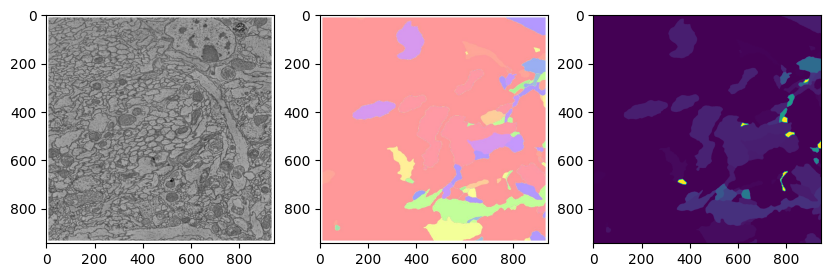

In [40]:
data_dir = os.path.join(".","plain")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

def extract_integers(s):
    return [int(num) for num in re.findall(r'\d+', s)]

def check_index(search_lst):
    intlst = []
    for i in search_lst:
        if i != ".DS_Store":
            intlst.append(extract_integers(i)[0])
    unique_lst = list(set(intlst))
    unique_lst.sort()
    return unique_lst

def image_open(dir, num, backbone):
    img = Image.open(dir + "/" + str(num) + backbone).convert("RGB")
    # img = img.resize((1200, 1200))
    bbox = img.getbbox()
    img = img.crop(bbox)
    return img

backbone_raw = "_raw.jpeg"
backbone_rawindex = "_raw.npy"
backbone_cleft = "_cleft.jpeg"
backbone_cleftindex = "_cleft.npy"
backbone_neuron = "_neuron.jpeg"
backbone_neuronindex = "_neuron.npy"

train_int = check_index(train_fns)
# print(train_int)
val_int = check_index(val_fns)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
raw_testimg = image_open(train_dir, train_int[0], backbone_raw)
raw_index = np.load(train_dir + "/" + str(train_int[0]) + backbone_rawindex) # neuron index read from file
neuron_testimg = image_open(train_dir, train_int[0], backbone_neuron)
neuron_index = np.load(train_dir + "/" + str(train_int[0]) + backbone_neuronindex) # neuron index read from file

def ndarray_to_image(array):
    """
    Convert a NumPy array to a PIL Image object.

    Parameters:
    - array: A NumPy array to be converted.

    Returns:
    - A PIL Image object.
    """
    # Ensure the array is of type uint8
    if array.dtype != np.uint8:
        # Normalize and convert the data to uint8
        array = ((array - array.min()) / (array.max() - array.min()) * 255).astype(np.uint8)
    return Image.fromarray(array)

neuron_index = skimage.transform.resize(neuron_index, (944,944))
neuron_index = ndarray_to_image(neuron_index)

axes[0].imshow(raw_testimg)
axes[1].imshow(neuron_testimg)
axes[2].imshow(neuron_index)

In [41]:
num_items = 10000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(10000, 3)
[[ 60  31  79]
 [157   2 176]
 [102 172 217]
 [ 10  63 237]
 [ 66 170 236]]


In [99]:
num_classes = 15
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/opt/homebrew/Caskroom/miniforge/base/envs/uwzihan/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=15)

In [100]:
label_model.predict(color_array[:5, :])

array([5, 7, 1, 8, 3], dtype=int32)

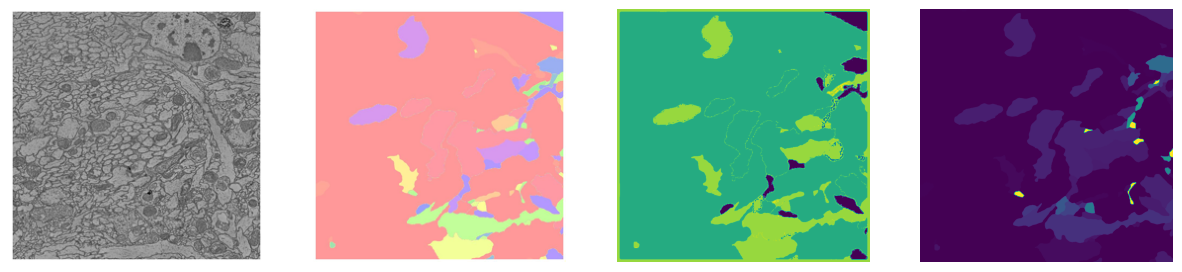

In [101]:
label_class = label_model.predict(np.array(neuron_testimg).reshape(-1, 3)).reshape(944, 944)

raw_index = skimage.transform.resize(raw_index, (256,256))
# neuron_index = skimage.transform.resize(neuron_index, (256,256))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(raw_testimg.resize((256,256)))
axes[1].imshow(neuron_testimg.resize((256,256)))
axes[2].imshow(label_class)
axes[3].imshow(neuron_index)

for ax in axes:
    ax.axis('off')

In [102]:
def apply_clahe(img):
    img_np = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img_np.shape) == 2:  # Grayscale image
        img_clahe = clahe.apply(img_np)
    else:  # Color image
        img_clahe = np.dstack([clahe.apply(i) for i in cv2.split(img_np)])
    return Image.fromarray(img_clahe)

# Define a custom transform for Canny edge detection
def apply_canny(img):
    img_np = np.array(img.convert('L'))  # Convert to grayscale
    edges = cv2.Canny(img_np, 100, 200)
    return Image.fromarray(edges).convert('RGB')  # Convert back to RGB

# Define a custom transform for Gaussian blur
def apply_gaussian_blur(img):
    return img.filter(ImageFilter.GaussianBlur(5))

In [103]:
class NeuronDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.index_lst = check_index(self.image_fns)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns) // 6
    
    def __getitem__(self, index):
        # assert index in self.index_lst
        raw_testimg = image_open(train_dir, index, backbone_raw)
        raw_index = np.load(train_dir + "/" + str(train_int[0]) + backbone_rawindex) # neuron index read from file
        neuron_testimg = image_open(train_dir, index, backbone_neuron).resize((256,256))
        label_class = label_model.predict(np.array(neuron_testimg).reshape(-1, 3)).reshape(256, 256)
        neuron_index = np.load(train_dir + "/" + str(index) + backbone_neuronindex)
         
        raw_index = skimage.transform.resize(raw_index, (256,256))
        neuron_index = skimage.transform.resize(neuron_index, (256,256)) 
        raw_testimg = raw_testimg.resize((256,256))
        # label_class = skimage.transform.resize(label_class, (256,256))

        test = 0

        if test == 1:
            plt.figure()
            plt.imshow(raw_testimg)
    
        # preprocess
        raw_testimg = self.transform(raw_testimg)
        # print(raw_testimg.shape)

        if test == 1:
            plt.figure()
            plt.imshow(raw_testimg.numpy()[0])
            # plt.figure()
            # plt.imshow(raw_testimg.numpy()[1])
            # plt.figure()
            # plt.imshow(raw_testimg.numpy()[2])
        
        raw_index = torch.Tensor(raw_index).long() 
        minval = np.min(neuron_index)
        neuron_index = torch.Tensor(neuron_index / minval).long()

        if test == 1: 
            print(label_class)

        # label_class = preprocess_bd(label_class)
        label_class = torch.Tensor(label_class).long()

        if test == 1: 
            # print(label_class.numpy())
            plt.figure()
            plt.imshow(label_class)
         
        return raw_testimg, label_class
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            # transforms.Lambda(lambda img: apply_gaussian_blur(img)),
            transforms.Lambda(lambda img: apply_clahe(img)),
            transforms.Lambda(lambda img: apply_canny(img)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)



279
[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]]
torch.Size([3, 256, 256]) torch.Size([256, 256])


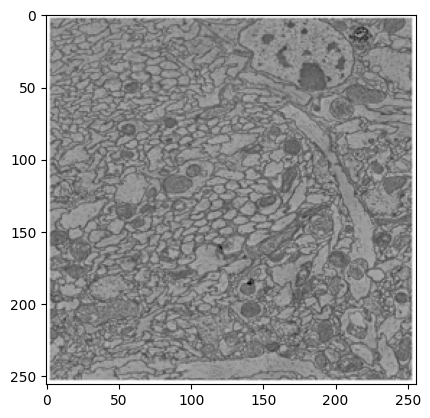

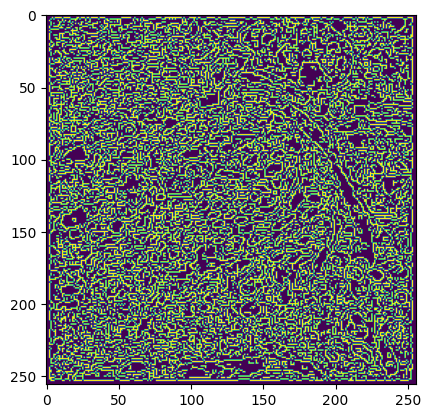

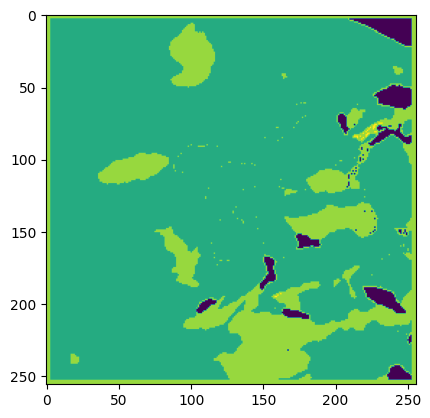

In [104]:
dataset = NeuronDataset(train_dir, label_model)
print(len(dataset))
raw_image, label_class = dataset[0]
print(raw_image.shape, label_class.shape)

In [105]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [106]:
model = UNet(num_classes=num_classes)

In [107]:
batch_size = 32

epochs = 10
lr = 0.01

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]]
[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]]
[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]]
[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]]
[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]]
[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 ...
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]]
[[12 12 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12 12 12 ...

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_56015/2637166800.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: 

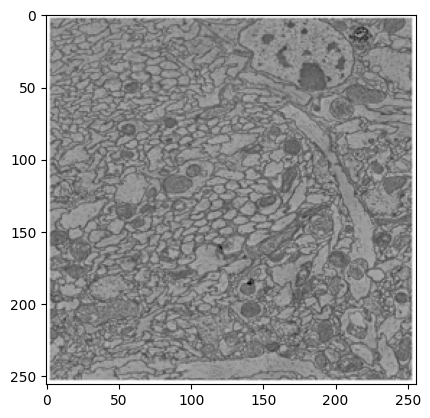

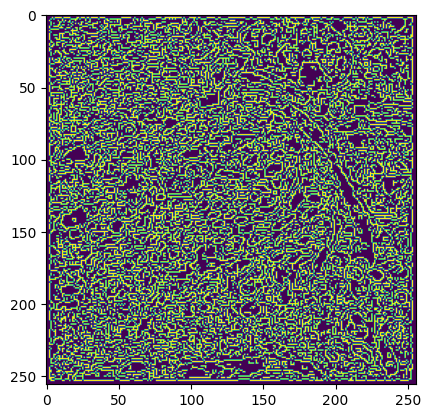

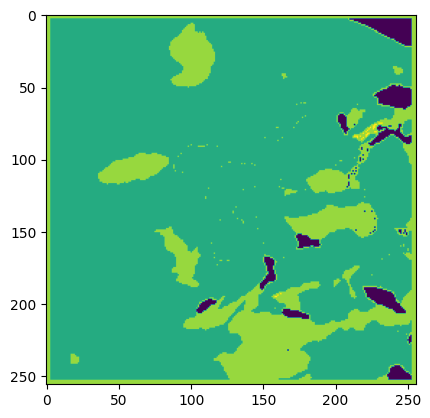

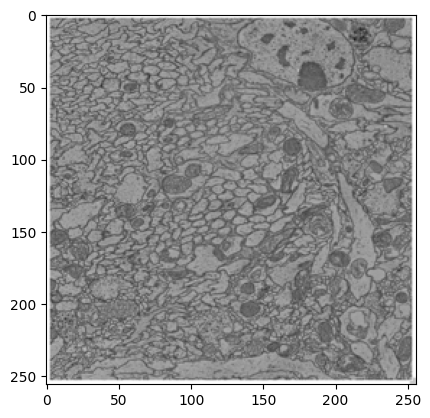

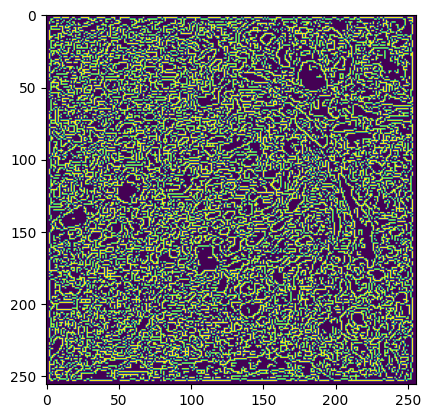

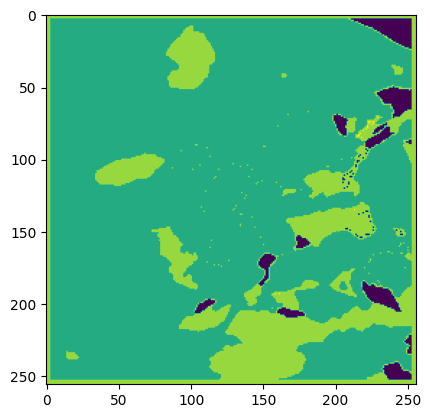

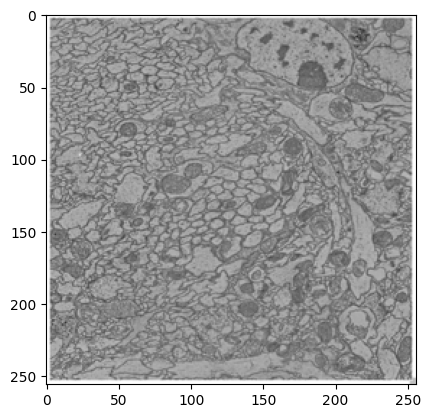

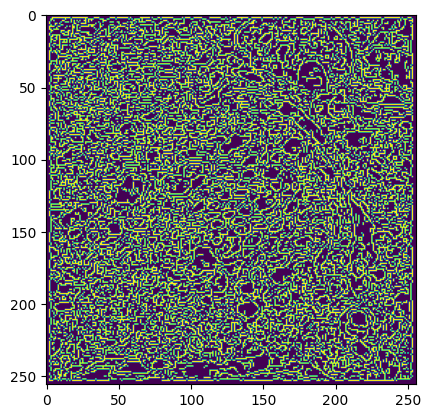

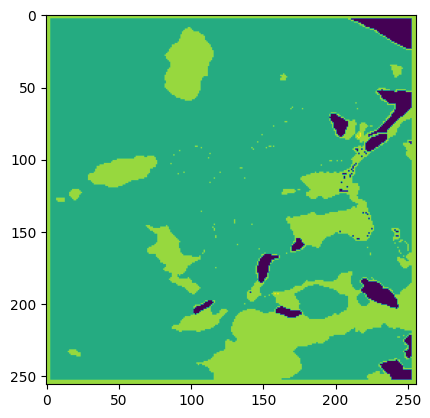

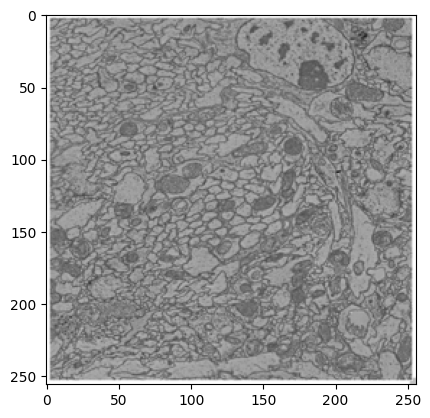

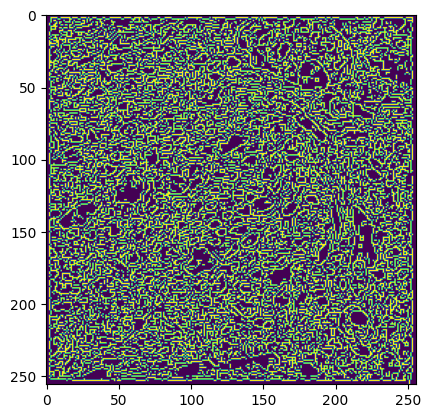

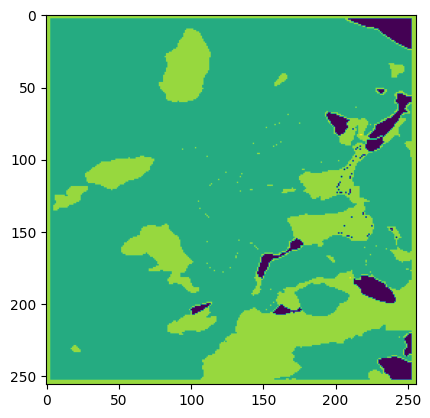

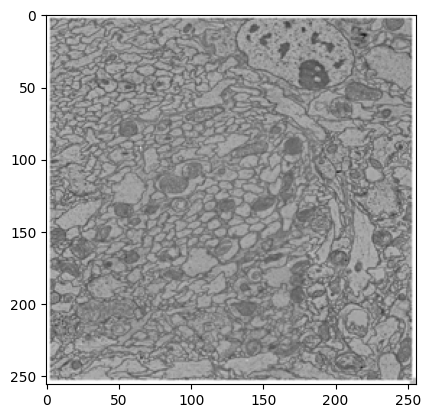

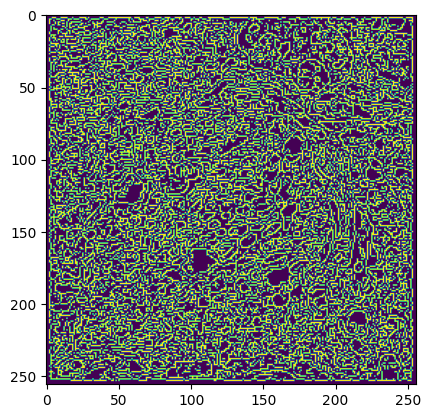

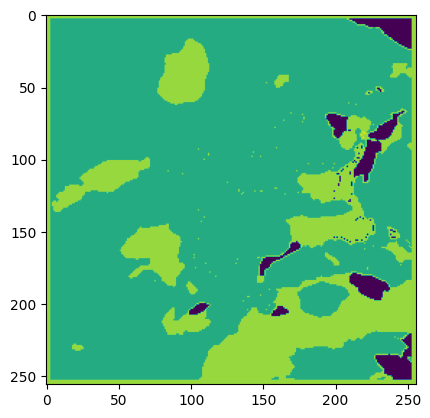

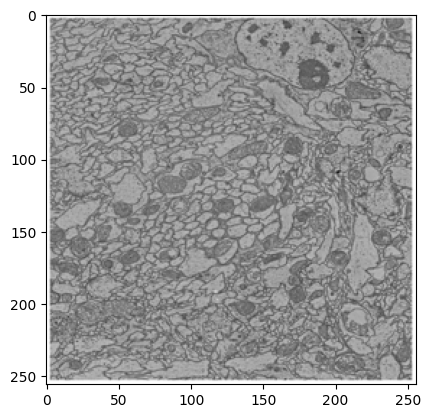

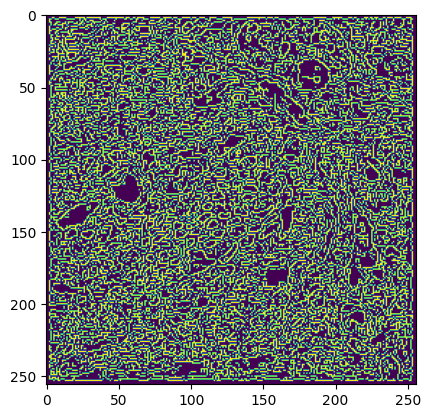

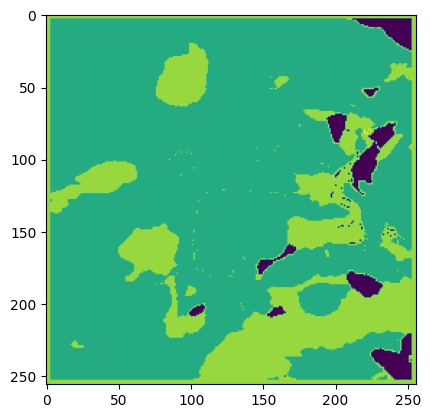

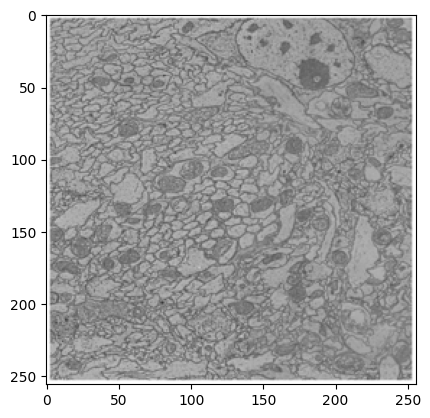

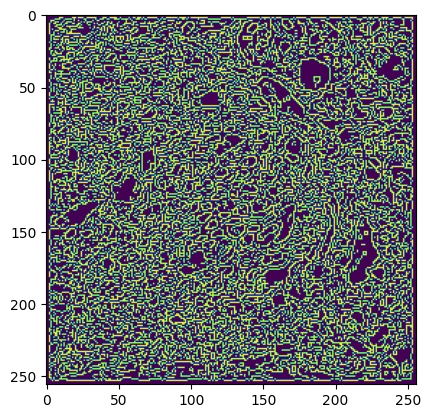

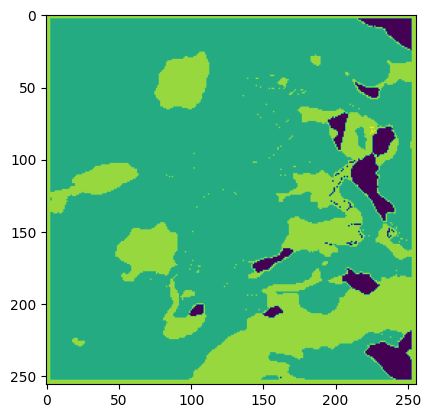

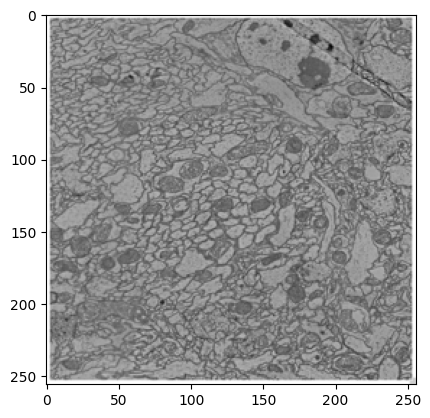

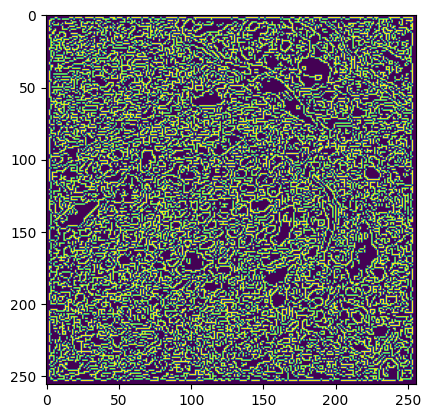

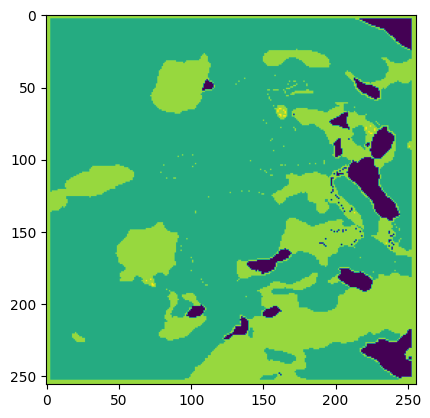

In [108]:
dataset = NeuronDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)
model = UNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = DiceLoss()
optimizer = optim.Adam(model.parameters())


step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))